In [2]:
import gym
import torch

from src.Learner.AWAC import AWAC
from src.Learner.DQN import DQN
from src.Learner.Random import DiscreteRandomAgent
from src.nn.MLP import MLP
from src.utils.memory import ReplayMemory
from src.utils.train_utils import prepare_training_inputs

import matplotlib.pyplot as plt

C:\Users\Go\miniconda3\envs\pro1\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


(array([0.01864407, 0.01525424, 0.01186441, 0.01864407, 0.00508475,
        0.00677966, 0.        , 0.00338983, 0.00169492, 0.00338983]),
 array([ 12. ,  23.8,  35.6,  47.4,  59.2,  71. ,  82.8,  94.6, 106.4,
        118.2, 130. ]),
 <BarContainer object of 10 artists>)

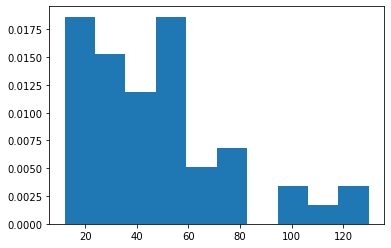

In [3]:
gamma = 0.9
memory_size = 500000
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

use_expert = True
if use_expert:    
    qnet = MLP(4, 2, num_neurons=[128])
    qnet_target = MLP(4, 2, num_neurons=[128])
    dqn = DQN(4, 1, qnet=qnet,qnet_target=qnet_target, lr=1e-4, gamma=gamma, epsilon=1.0)
    state_dict = torch.load('dqn_agent.pt')
    
    # make trained agent slightly dumb
    # to simulate the realistic scenario where we don't have 'perfect' policy
    # but good enough policy.
    
    state_dict['epsilon'] = dqn.epsilon * .4 
    dqn.load_state_dict(state_dict)    
    offline_agent = dqn
    offline_budget = 50
else:
    offline_agent = DiscreteRandomAgent(2)
    offline_budget = 300

online_budget = offline_budget
cum_rs = []
for n_epi in range(offline_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = offline_agent.get_action(s)
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if done:
            cum_rs.append(cum_r)
            break
plt.hist(cum_rs, density=True, label='expert')

fitting [0] / [1000]


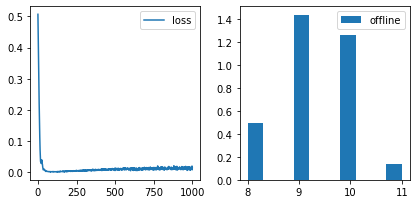

In [8]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


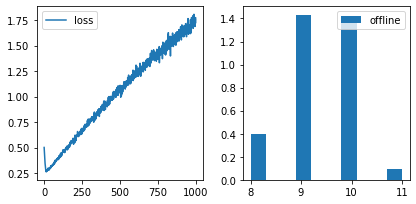

In [9]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


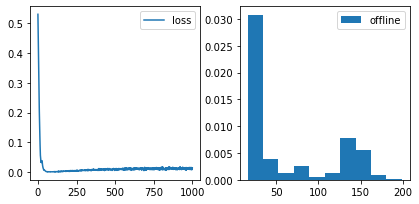

In [10]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


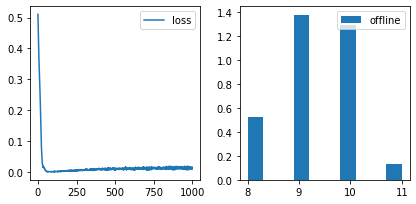

In [11]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


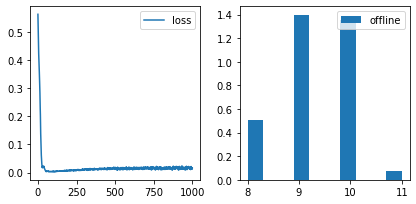

In [12]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


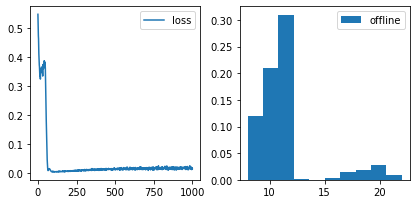

In [18]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


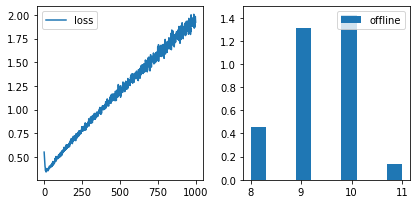

In [19]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


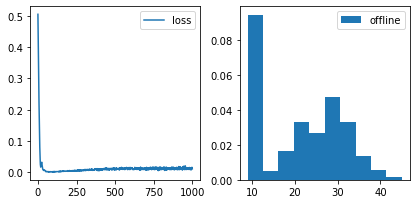

In [20]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


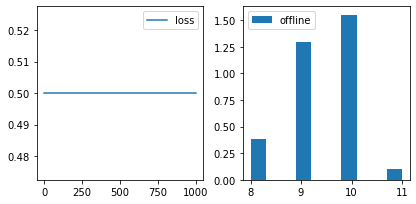

In [21]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


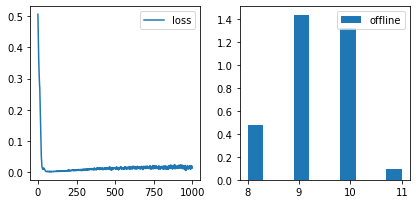

In [22]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


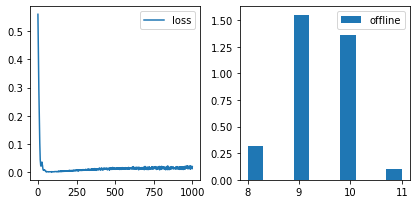

In [13]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128])
qnet_target = MLP(4, 2, num_neurons=[128,128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


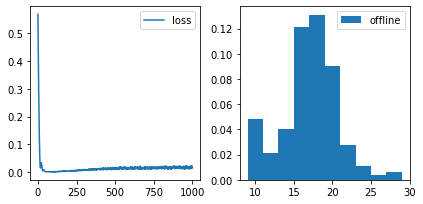

In [14]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128])
qnet_target = MLP(4, 2, num_neurons=[128,128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


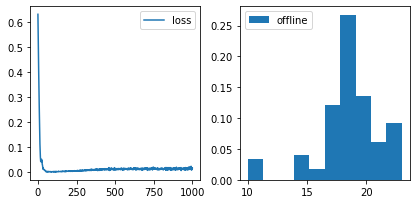

In [15]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128])
qnet_target = MLP(4, 2, num_neurons=[128,128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


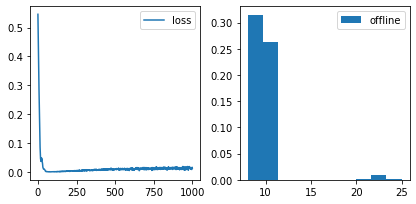

In [16]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128])
qnet_target = MLP(4, 2, num_neurons=[128,128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


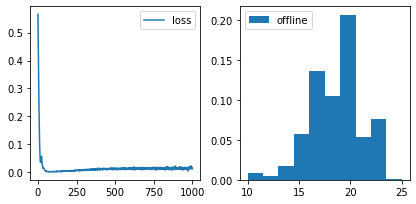

In [17]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128])
qnet_target = MLP(4, 2, num_neurons=[128,128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


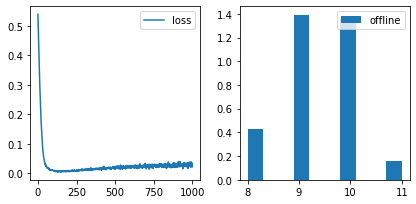

In [23]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


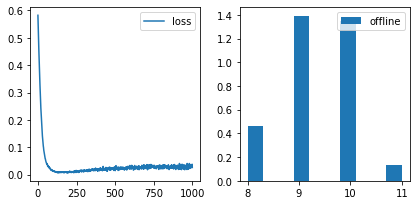

In [24]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


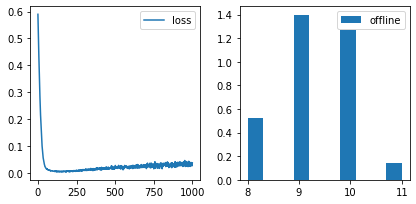

In [25]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


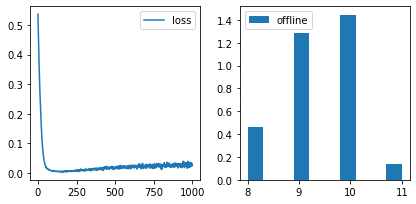

In [26]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


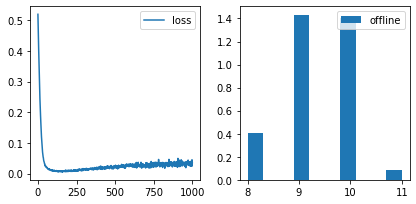

In [27]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


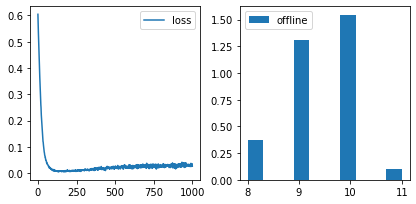

In [28]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [1000]


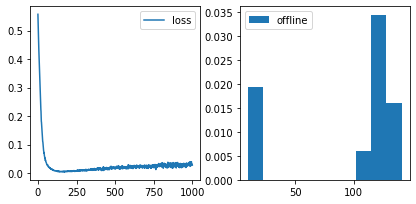

In [29]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


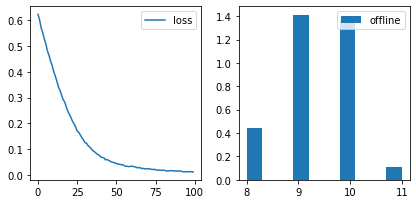

In [30]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


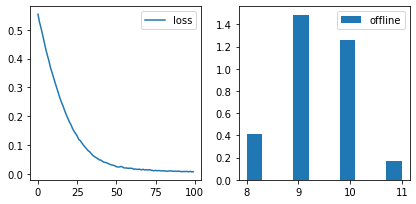

In [31]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


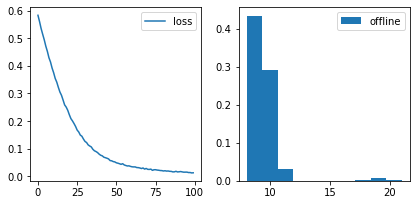

In [32]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


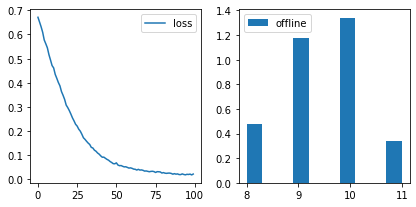

In [33]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


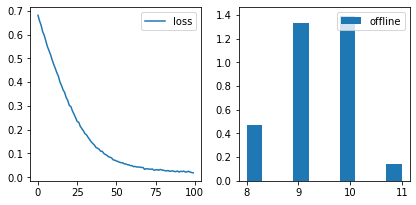

In [34]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


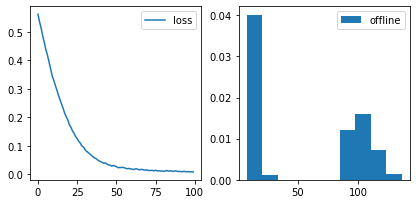

In [35]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


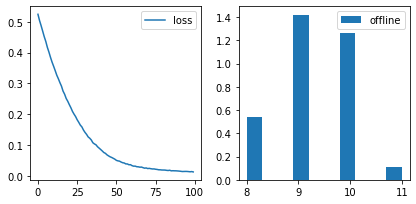

In [36]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


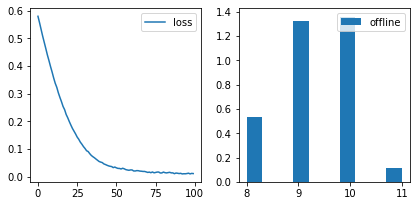

In [37]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


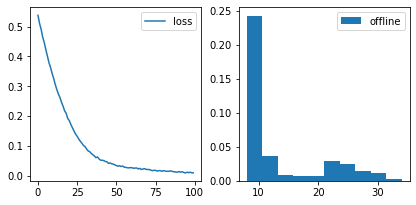

In [38]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


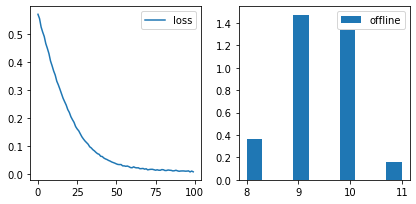

In [39]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

fitting [0] / [100]


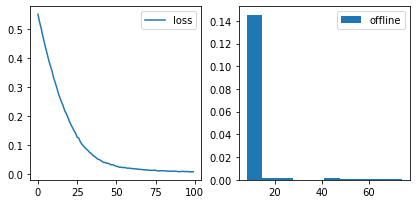

In [40]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

batch_size = 1024
n_updates = 100
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()


num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()